## A/B Testing 

### Investiage the effect of changing pricing option.

#### Company XYZ sells a software for $\$39$. Since revenue has been ﬂat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ($\$39$), while a random sample of 33% users a higher price ($\$59$). The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. Especially he asked you the following questions:

1. **Should the company sell its software for $\$39$ or $\$59$?**

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data? 

3. [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically signiﬁcant results in a shorter time. Do you agree with her intuition? **After how many days you would have stopped the test?** Please, explain why.

In [1]:
import  warnings
warnings.simplefilter('ignore')
from pprint import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
user_table = pd.read_csv('user_table.csv')
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [3]:
pprint(user_table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB
None


In [4]:
pprint(user_table.isnull().sum())

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64


In [5]:
test_results = pd.read_csv('test_results.csv', parse_dates=['timestamp'])
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


## Data processing and cleaning

### check uniquess from two tables

In [6]:
print("There are {} rows in user table".format(len(user_table['user_id'].unique())))
print("There are {} rows in test table".format(len(test_results['user_id'].unique())))


There are 275616 rows in user table
There are 316800 rows in test table


In [7]:
data = pd.merge(left=test_results, right=user_table, how='left', on='user_id')
data.head(10)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0,New York,USA,40.67,-73.94
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,East Orange,USA,40.77,-74.21
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,Dayton,USA,39.78,-84.20
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0,Richmond,USA,37.53,-77.47


In [8]:
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count().reset_index()

,test,price,user_id
0,0,39,202517
1,0,59,210
2,1,39,155
3,1,59,113918


#### It seems that there are some problems with the data

1. there are a small amount of users who are labelled with `test=0` but actually see price $\$59$.
2. there are a small amount of users who are labelled with `test=1` but actually see price $\$39$. 

Fortunately, they are only a very small portion of the whole dataset. The first step is to *remove these problematic inputs*.

Then created a new column `Revenue`

In [9]:
# only keep the valid data
data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]
data['revenue'] = data['converted'] * data['price']
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [10]:
pprint(data.isnull().sum())

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64


In [11]:
temp = data.groupby('test',as_index=False)['source'].apply(lambda x: x.value_counts(normalize=True)).reset_index(name ='Revenue')#.unstack(level=0)
temp.head()

,level_0,level_1,Revenue
0,0,direct_traffic,0.191154
1,0,ads-google,0.186873
2,0,ads_facebook,0.168253
3,0,ads_other,0.095083
4,0,seo-google,0.074502


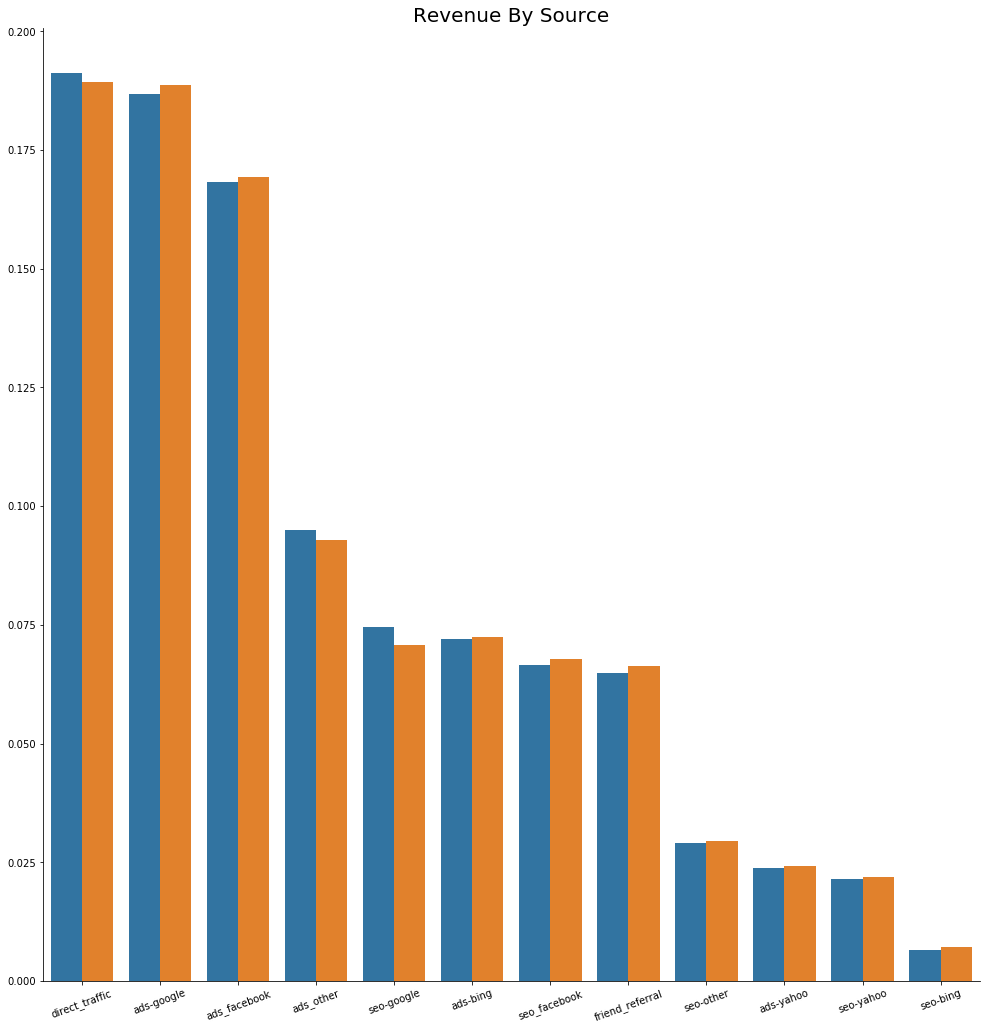

In [12]:
#sns.set(rc={"font.size":15,"axes.labelsize":15})

p = sns.catplot(x="level_1", y="Revenue",hue="level_0",data=temp, kind="bar",height=14, legend = False)
plt.title("Revenue By Source", {'fontsize': 20})
plt.xlabel('')
plt.ylabel('')
p.set_xticklabels(rotation=20)

## Q1:
### Should the company sell its software for $\$59$ or $\$39$ ?



In [13]:
data[['test', 'converted']].groupby('test').mean().reset_index()

,test,converted
0,0,0.019900
1,1,0.015555


In [14]:
data[['test', 'revenue']].groupby('test').mean().reset_index()

,test,revenue
0,0,0.776083
1,1,0.917748


Clearly, for those with lower price $\$39$, they have a higher conversion rate $1.990\%$. For those with higher price $\$59$, the conversion rate is $1.556\%$. However, considering the price, the average revenue for higher price ($0.918$) is actually larger than the lower price ($0.776$).

## Now, let's conduct hypothesis testing.

#### * $H_\theta$: experimental group's average revenue is equal to or less than control group's average revenue
#### * $H_\alpha$: experimental group's average revenue is higher than control group's average revenue


`equal_var=False` Welch’s t-test, unlike Student’s t-test, *does not have the assumption of equal variance (however, both tests have the assumption of normality).* When two groups have equal sample sizes and variances, Welch’s tends to give the same result as Student’s. `However, when sample sizes and variances are unequal, Student’s t-test is quite unreliable; Welch’s tends perform better`

In [15]:
ctr_val = data[data['test'] == 0]['revenue'].values
exp_val = data[data['test'] == 1]['revenue'].values

pprint(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


The above test is actually two tailed test. What we want is one-tailed test. However, from above result, we can easily conclude that even for one-tailed test, we can safely conclude that we can reject the null hypothesis, and conclude that experimental group's average revenue is higher than control group's average revenue.

Although our test suggest that $\$59$ price can give us higher average revenue. However, due to the problem with the A/B test, the above result is not scientifically accurate. More scientific A/B test is needed.

# Q2

### The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

### Investigate the Source

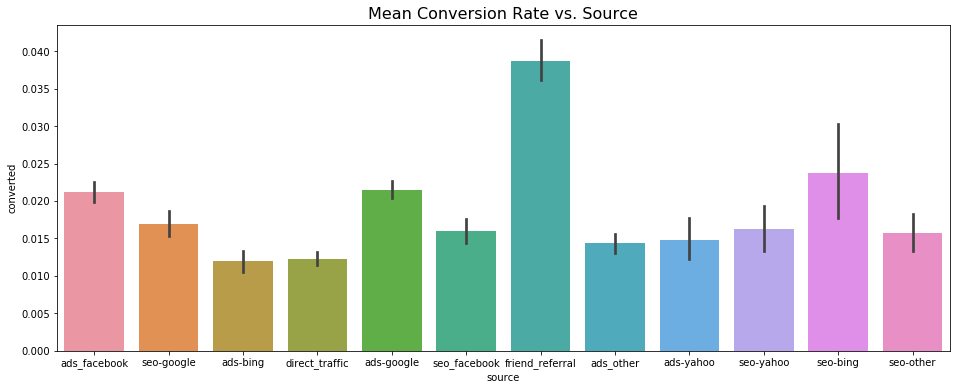

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

In [17]:
data[['source', 'converted']].groupby('source').mean().reset_index().sort_values(by=['converted'], ascending= False)

,source,converted
6,friend_referral,0.038688
7,seo-bing,0.023787
1,ads-google,0.021502
3,ads_facebook,0.021198
8,seo-google,0.016978
10,seo-yahoo,0.016226
11,seo_facebook,0.016051
9,seo-other,0.015686
2,ads-yahoo,0.014793
4,ads_other,0.014350


# Visualization of source


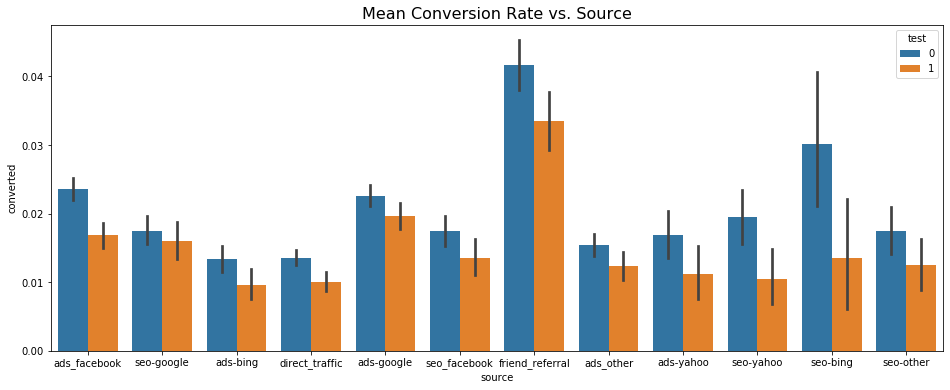

In [18]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

In [19]:
data[['source', 'test','converted']].groupby(['source', 'test']).mean().reset_index().sort_values(by=['source','converted'], ascending= False)

,source,test,converted
22,seo_facebook,0,0.017458
23,seo_facebook,1,0.013598
20,seo-yahoo,0,0.019513
21,seo-yahoo,1,0.010463
18,seo-other,0,0.017520
19,seo-other,1,0.012481
16,seo-google,0,0.017497
17,seo-google,1,0.016005
14,seo-bing,0,0.030098
15,seo-bing,1,0.013497


# Investigate the Device

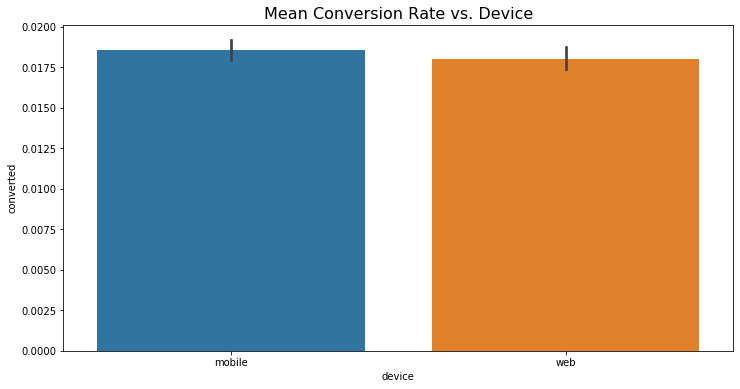

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

In [21]:
data[['device','converted']].groupby(['device']).mean().reset_index().sort_values(by=['device'], ascending= False)

,device,converted
1,web,0.018023
0,mobile,0.018554


# Q3

### [Bonus] The VP of Product that the test has been running for too long and they have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please explain why.

In [22]:
data.groupby('source')['converted'].mean().reset_index()

,source,converted
0,ads-bing,0.012001
1,ads-google,0.021502
2,ads-yahoo,0.014793
3,ads_facebook,0.021198
4,ads_other,0.014350
5,direct_traffic,0.012294
6,friend_referral,0.038688
7,seo-bing,0.023787
8,seo-google,0.016978
9,seo-other,0.015686


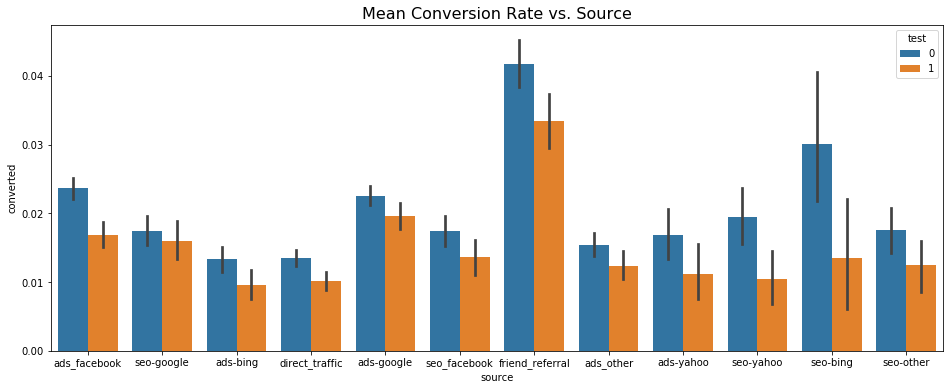

In [23]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

In [24]:
data.groupby(['device', 'test'])['converted'].mean().reset_index()

,device,test,converted
0,mobile,0,0.019872
1,mobile,1,0.016146
2,web,0,0.019940
3,web,1,0.014744


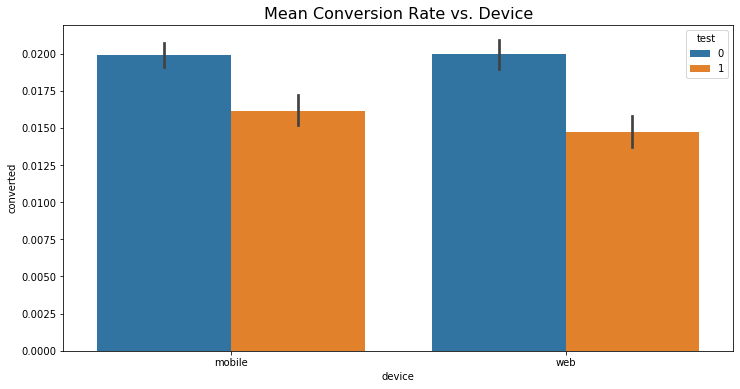

In [25]:
# Visualization of device
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted',hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

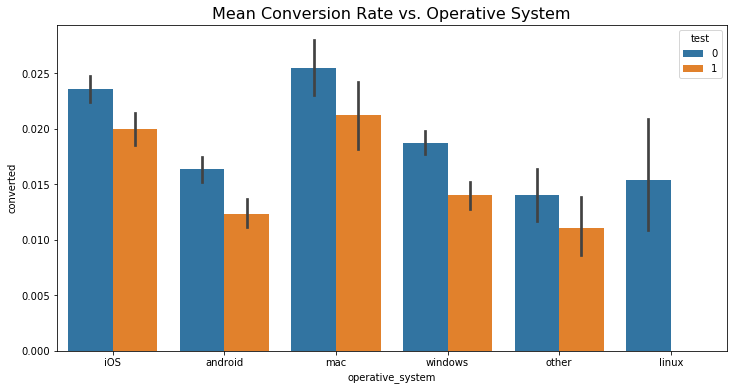

In [26]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

From above visualizations, we can easily conclude that price dramatically influence the conversion rate. But beside price, there are still other factors that can influence the conversion rate.
* Source
    - Friend-referral users have much higher conversion rate
* Device
    - The influence of device is not significant
* Operative System
    - Mac and ios users have much higher conversion rate

### Actionable Insights (refer to online resource)
friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate
if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors
* lauch special marketing program targeted to Apple users (MAC or iOS users)
* run some program which rewards user which can invite his/her friend to use our software
* Linux users don't like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?